In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize
from IPython.display import clear_output
from matplotlib import ticker

from notebooks.utils import *

In [2]:
from datetime import datetime, timezone
from zoneinfo import ZoneInfo

dt_local = datetime(2025, 9, 13, 21, 0, tzinfo=ZoneInfo("Europe/Zurich"))
dt_utc = dt_local.astimezone(timezone.utc)

runs, histories, config_df = load_runs(
    filters={
        # "tags": "crit_bs_l8_d512",
        "$and": [
            # {"$not": {"tags": "flagged"}},
            {"$or": [
                {"tags": "crit_bs_l8_d512"},
                {"tags": "crit_bs_l12_d768"},
                {"tags": "crit_bs_l16_d1024"},
                {"tags": "scaling_laws"},
            ]},
            {"created_at": {"$gte": dt_utc.isoformat()}}
        ],
    },
    order="+created_at",
    drop_duplicates=["num_layers", "hidden_size", "learning_rate", "batch_size", "hybrid_mixing_shift"],
)

# config_df = config_df.sort_values(["total_steps", "final_elbo"], ascending=[False, True])#.drop_duplicates(subset=["num_layers", "hidden_size", "learning_rate", "batch_size", "hybrid_mixing_shift"])
len(config_df)

Processing runs:   0%|          | 0/510 [00:00<?, ?it/s]

Skipping run gidd-L8-D512-H8-N2048-bs=32-lr=0.3-noise_mask with insufficient steps: None
Skipping run gidd-L8-D512-H8-N2048-bs=256-lr=0.5-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_low_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_high_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_balanced with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_high_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_balanced with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_mask with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048

421

In [3]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [4]:
max_loss = 4.4
min_loss = float(min(h["train/elbo_ema"].min() for h in histories if "train/elbo_ema" in h))

loss_targets = np.logspace(np.log10(min_loss), np.log10(max_loss), 17)[::-1]

In [5]:
def f(xs, a=1.0, alpha=0.1, b=1.0, beta=1.0, c=1.0, gamma=1e-4, E=0.0):
    return np.exp(a) * xs[0]**-np.exp(alpha) + np.exp(b) * (xs[1])**-np.exp(beta) + np.exp(c) * xs[2]**-np.exp(gamma) + np.exp(E)

def loss(params, steps, batch_size, popt=None):
    assert popt is not None
    return f((params, steps, batch_size), *popt)

def loss_from_tokens(params, tokens, batch_size=None, steps=None, popt=None):
    assert popt is not None
    assert not (steps is None and batch_size is None)
    if steps is None:
        steps = tokens / batch_size
    if batch_size is None:
        batch_size = tokens / steps
    return f((params, steps, batch_size), *popt)

def loss_from_flops(flops, batch_size, params=None, tokens=None, popt=None):
    assert popt is not None
    assert not (tokens is None and params is None)
    if tokens is None:
        tokens = flops / (6*params)
    if params is None:
        params = flops / (6*tokens)
    steps = tokens / batch_size
    return f((params, steps, batch_size), *popt)

In [6]:
df_ = config_df
# df_ = df_.loc[df_.groupby(["num_layers", "batch_size", "hybrid_mixing_shift"])["final_elbo"].idxmin()]
loss_df = df_.merge(pd.DataFrame({"target_loss": loss_targets}), how="cross")

def annotate_row(row):
    steps = steps_at_loss(row["target_loss"], row)
    if steps < 2000 or steps > row["total_steps"]:
        return row
    row["steps"] = steps
    row["tokens"] = steps * row["batch_size"] * row["max_seq_len"]
    row["flops"] = 6 * row["non_emb_params"] * row["tokens"]
    # row["tokens"] = tokens_at_loss(row["target_loss"], row)
    # row["flops"] = flops_at_loss(row["target_loss"], row)
    return row

loss_df = loss_df.apply(annotate_row, axis=1).dropna(subset=["steps"])

clear_output()

In [7]:
popts = {}

for hybrid_mixing_shift, dfi in loss_df.groupby("hybrid_mixing_shift"):
    params = dfi["non_emb_params"]
    batch_size = dfi["batch_size"] * dfi["max_seq_len"]
    tokens = dfi["tokens"]
    # steps = dfi["steps"]
    steps = tokens / batch_size
    loss = dfi["target_loss"]

    popt, pcov = curve_fit(
        f,
        (params, steps, batch_size),
        loss,
        p0=(0.0, -4.0, 0.0, -1.0, 0.0, -3.0, 0.0),
        maxfev=100_000,
    )
    mse = np.mean((f((params, steps, batch_size), *popt) - loss)**2)
    print("MSE: {:.4g}, Params: {:.2f}*P^{{{:.4g}}} + {:.2f}*S^{{{:.4g}}} + {:.2f}*B^{{{:.4g}}} + {:.2f}".format(mse, *np.exp(popt)))

    popts[hybrid_mixing_shift] = popt

MSE: 0.005995, Params: 66.37*P^{0.2941} + 20.37*S^{0.3325} + 14.99*B^{0.1997} + 0.95
MSE: 0.005261, Params: 45.62*P^{0.2664} + 17.27*S^{0.3043} + 12.88*B^{0.1761} + 0.67
MSE: 0.005156, Params: 18.55*P^{0.2002} + 15.79*S^{0.2883} + 11.55*B^{0.1575} + 0.33
MSE: 0.005521, Params: 12.07*P^{0.1648} + 16.34*S^{0.2939} + 10.90*B^{0.1512} + 0.23
MSE: 0.005338, Params: 8.15*P^{0.1291} + 19.32*S^{0.3181} + 10.64*B^{0.145} + 0.02


In [8]:
def opt_bs_at_tokens(params, tokens, popt):
    def to_solve(batch_size):
        steps = tokens / batch_size
        return np.log(f((params, steps, batch_size), *popt))
    optimal_bs = minimize(to_solve, x0=256*2048).x[0]
    return optimal_bs

Text(0, 0.5, 'Optimal Batch Size')

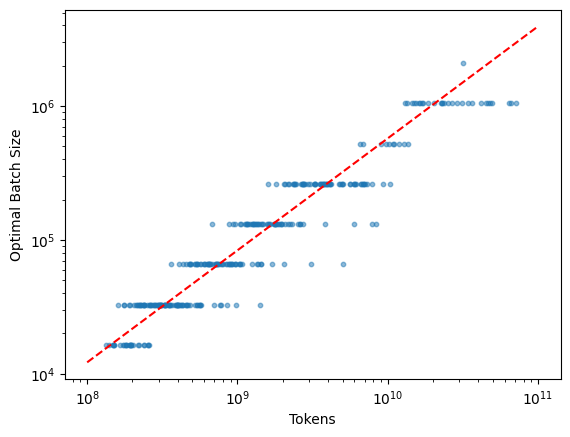

In [9]:
df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "target_loss"])["tokens"].idxmin()]

plt.scatter(df_["tokens"], df_["batch_size"]*2048, alpha=0.5, s=10)

xs = np.logspace(8, 11, 50)
ys = 10**-2.609 * xs**0.8368
plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Tokens")
plt.ylabel("Optimal Batch Size")

1613.3805795860949 131912.96756299524 0.2783493151184447
142.85056038575337 11499.710713083128 0.15453362211033747
156.67183943554673 4456.3974932346955 0.15213834711368363
331.0724793007868 6478.5567689867685 0.18810800525006358
323.6834160321732 4655.62506837746 0.19231003889493595
269.8435889002452 3033.3812301247913 0.18814165333884897
146.108751886949 1218.9055739900318 0.16305218126700716
89.43150413572911 651.5121310929829 0.1497532894217437
200.3378719379929 1051.382929916339 0.18212497510759154
137.2140914189297 635.204405721937 0.16951480683345876
217.86051442090417 804.3743407516743 0.1933417046779688


Text(0, 0.5, 'Batch Size')

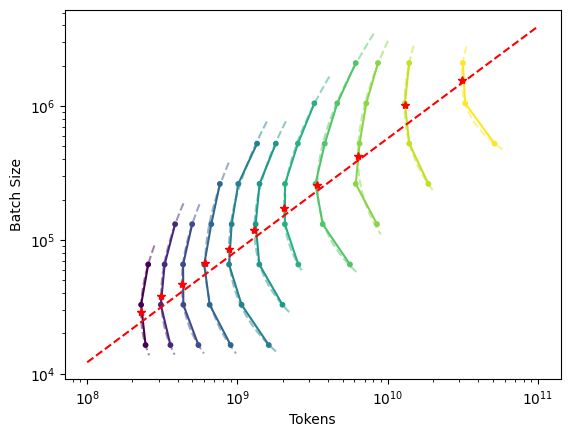

In [16]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs*ys, ys, alpha=1.0, color=color(target_loss))
    plt.scatter(xs*ys, ys, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return ((xs / a)**c - 1) * ((ys / b)**c - 1) - 1
    res = least_squares(resid, x0=[1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    # popt, _ = curve_fit(log_power_law, xs, np.log(ys), p0=(0.0, 0.1, -1.0), maxfev=100_000)
    # popt, _ = curve_fit(to_solve, np.array([xs, ys]), target, p0=(1.0, 1.0), maxfev=100_000)
    a, b, c = res.x

    x = np.logspace(np.log10(xs.min())-0.1, np.log10(xs.max())+0.1, 100)
    y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    # y_fit = np.exp(log_power_law(x_fit, *popt))
    plt.plot(x*y, y, "--", color=color(target_loss), alpha=0.5)
    print(a, b, c)

    opt_idx = np.argmin(x*y)
    plt.plot(x[opt_idx]*y[opt_idx], y[opt_idx], "*", color="red")


xs = np.logspace(8, 11, 50)
ys = 10**-2.609 * xs**0.8368
plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Tokens")
plt.ylabel("Batch Size")

1613.3805795860949 131912.96756299524 0.2783493151184447
142.85056038575337 11499.710713083128 0.15453362211033747
156.67183943554673 4456.3974932346955 0.15213834711368363
331.0724793007868 6478.5567689867685 0.18810800525006358
323.6834160321732 4655.62506837746 0.19231003889493595
269.8435889002452 3033.3812301247913 0.18814165333884897
146.108751886949 1218.9055739900318 0.16305218126700716
89.43150413572911 651.5121310929829 0.1497532894217437
200.3378719379929 1051.382929916339 0.18212497510759154
137.2140914189297 635.204405721937 0.16951480683345876
217.86051442090417 804.3743407516743 0.1933417046779688


Text(0, 0.5, 'Tokens')

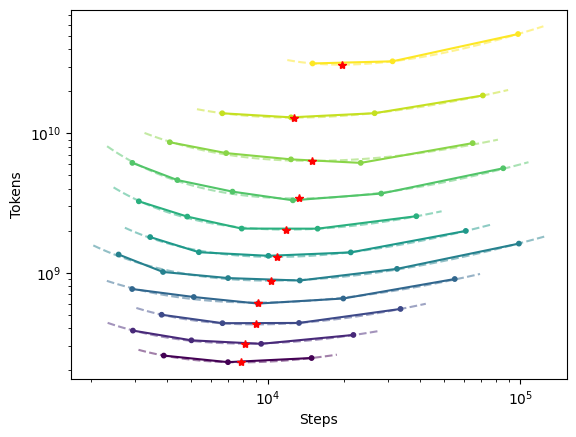

In [23]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs, ys*xs, alpha=1.0, color=color(target_loss))
    plt.scatter(xs, ys*xs, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return ((xs / a)**c - 1) * ((ys / b)**c - 1) - 1
    res = least_squares(resid, x0=[1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    # popt, _ = curve_fit(log_power_law, xs, np.log(ys), p0=(0.0, 0.1, -1.0), maxfev=100_000)
    # popt, _ = curve_fit(to_solve, np.array([xs, ys]), target, p0=(1.0, 1.0), maxfev=100_000)
    a, b, c = res.x

    x = np.logspace(np.log10(xs.min())-0.1, np.log10(xs.max())+0.1, 100)
    y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    # y_fit = np.exp(log_power_law(x_fit, *popt))
    plt.plot(x, y*x, "--", color=color(target_loss), alpha=0.5)
    print(a, b, c)

    opt_idx = np.argmin(x*y)
    plt.plot(x[opt_idx], y[opt_idx]*x[opt_idx], "*", color="red")


# xs = np.logspace(8, 11, 50)
# ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Steps")
plt.ylabel("Tokens")

1613.3805795860949 131912.96756299524 0.2783493151184447
142.85056038575337 11499.710713083128 0.15453362211033747
156.67183943554673 4456.3974932346955 0.15213834711368363
331.0724793007868 6478.5567689867685 0.18810800525006358
323.6834160321732 4655.62506837746 0.19231003889493595
269.8435889002452 3033.3812301247913 0.18814165333884897
146.108751886949 1218.9055739900318 0.16305218126700716
89.43150413572911 651.5121310929829 0.1497532894217437
200.3378719379929 1051.382929916339 0.18212497510759154
137.2140914189297 635.204405721937 0.16951480683345876
217.86051442090417 804.3743407516743 0.1933417046779688


Text(0, 0.5, 'Batch Size')

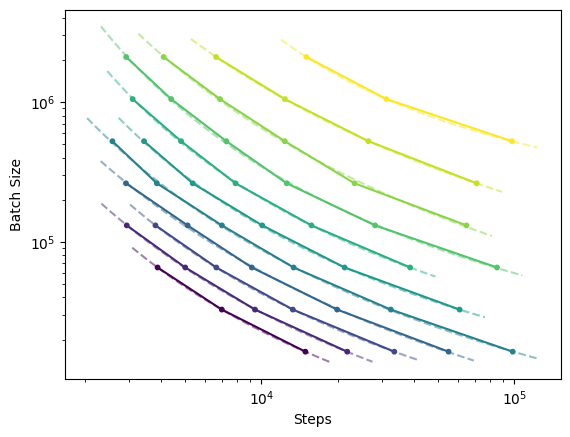

In [17]:
from scipy.optimize import least_squares

# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "batch_size"])["final_elbo"].idxmin()]
df_ = loss_df
df_ = df_.loc[(df_["hybrid_mixing_shift"] == 0.0) & (df_["num_layers"] == 8)]


def log_power_law(x, a, b, c):
    return np.log(np.exp(a) * x**-b + np.exp(c))

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

for target_loss, dfi in df_.groupby("target_loss"):
    # dfi = dfi.sort_values("batch_size")
    # dfi = dfi.loc[dfi["steps"] >= 5000]
    idx = dfi.groupby("batch_size")["steps"].idxmin()
    dfi = dfi.loc[idx]
    dfi = dfi.loc[dfi["steps"] >= 2500]
    ys = dfi["batch_size"]*2048
    # xs = dfi["tokens"] / ys
    xs = dfi["steps"]
    # print(target_loss)
    # print(dfi.loc["name"])
    plt.plot(xs, ys, alpha=1.0, color=color(target_loss))
    plt.scatter(xs, ys, c=dfi["target_loss"], alpha=1.0, s=10, cmap="viridis_r", vmin=vmin, vmax=vmax)

    if len(xs) < 3:
        continue

    def resid(p):
        a, b, c = p
        return ((xs / a)**c - 1) * ((ys / b)**c - 1) - 1
    res = least_squares(resid, x0=[1.0, 1.0, 1.0], bounds=(1e-8, np.inf))
    # popt, _ = curve_fit(log_power_law, xs, np.log(ys), p0=(0.0, 0.1, -1.0), maxfev=100_000)
    # popt, _ = curve_fit(to_solve, np.array([xs, ys]), target, p0=(1.0, 1.0), maxfev=100_000)
    a, b, c = res.x

    x = np.logspace(np.log10(xs.min())-0.1, np.log10(xs.max())+0.1, 100)
    y = b * np.power(((x / a)**c) / (((x / a)**c) - 1.0), 1.0 / c)
    # y_fit = np.exp(log_power_law(x_fit, *popt))
    plt.plot(x, y, "--", color=color(target_loss), alpha=0.5)
    print(a, b, c)

    # opt_idx = np.argmin(x*y)
    # plt.plot(x[opt_idx]*y[opt_idx], y[opt_idx], "*", color="red")


# xs = np.logspace(8, 11, 50)
# ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")
# plt.xlim(2000, None)

plt.xlabel("Steps")
plt.ylabel("Batch Size")

Params: 25.22M
Params: 49.24M
Params: 85.06M
Params: 201.56M
Params: 566.66M


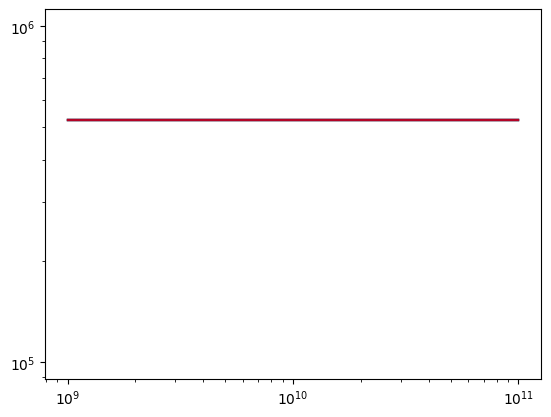

In [ ]:
fig, axs = plt.subplots(1, 1)

for params in sorted(config_df["non_emb_params"].unique()):
    print(f"Params: {params/1e6:.2f}M")
    token_targets = np.logspace(9, 11, 10)
    for hybrid_mixing_shift, popt in popts.items():
        optimal_bs = [opt_bs_at_tokens(params, toks, popt) for toks in token_targets]
        axs.plot(token_targets, optimal_bs, label=f"{get_noise_label(hybrid_mixing_shift)} ({hybrid_mixing_shift})", color=np.array(colors[hybrid_mixing_shift])/255)

axs.set_xscale("log")
axs.set_yscale("log")

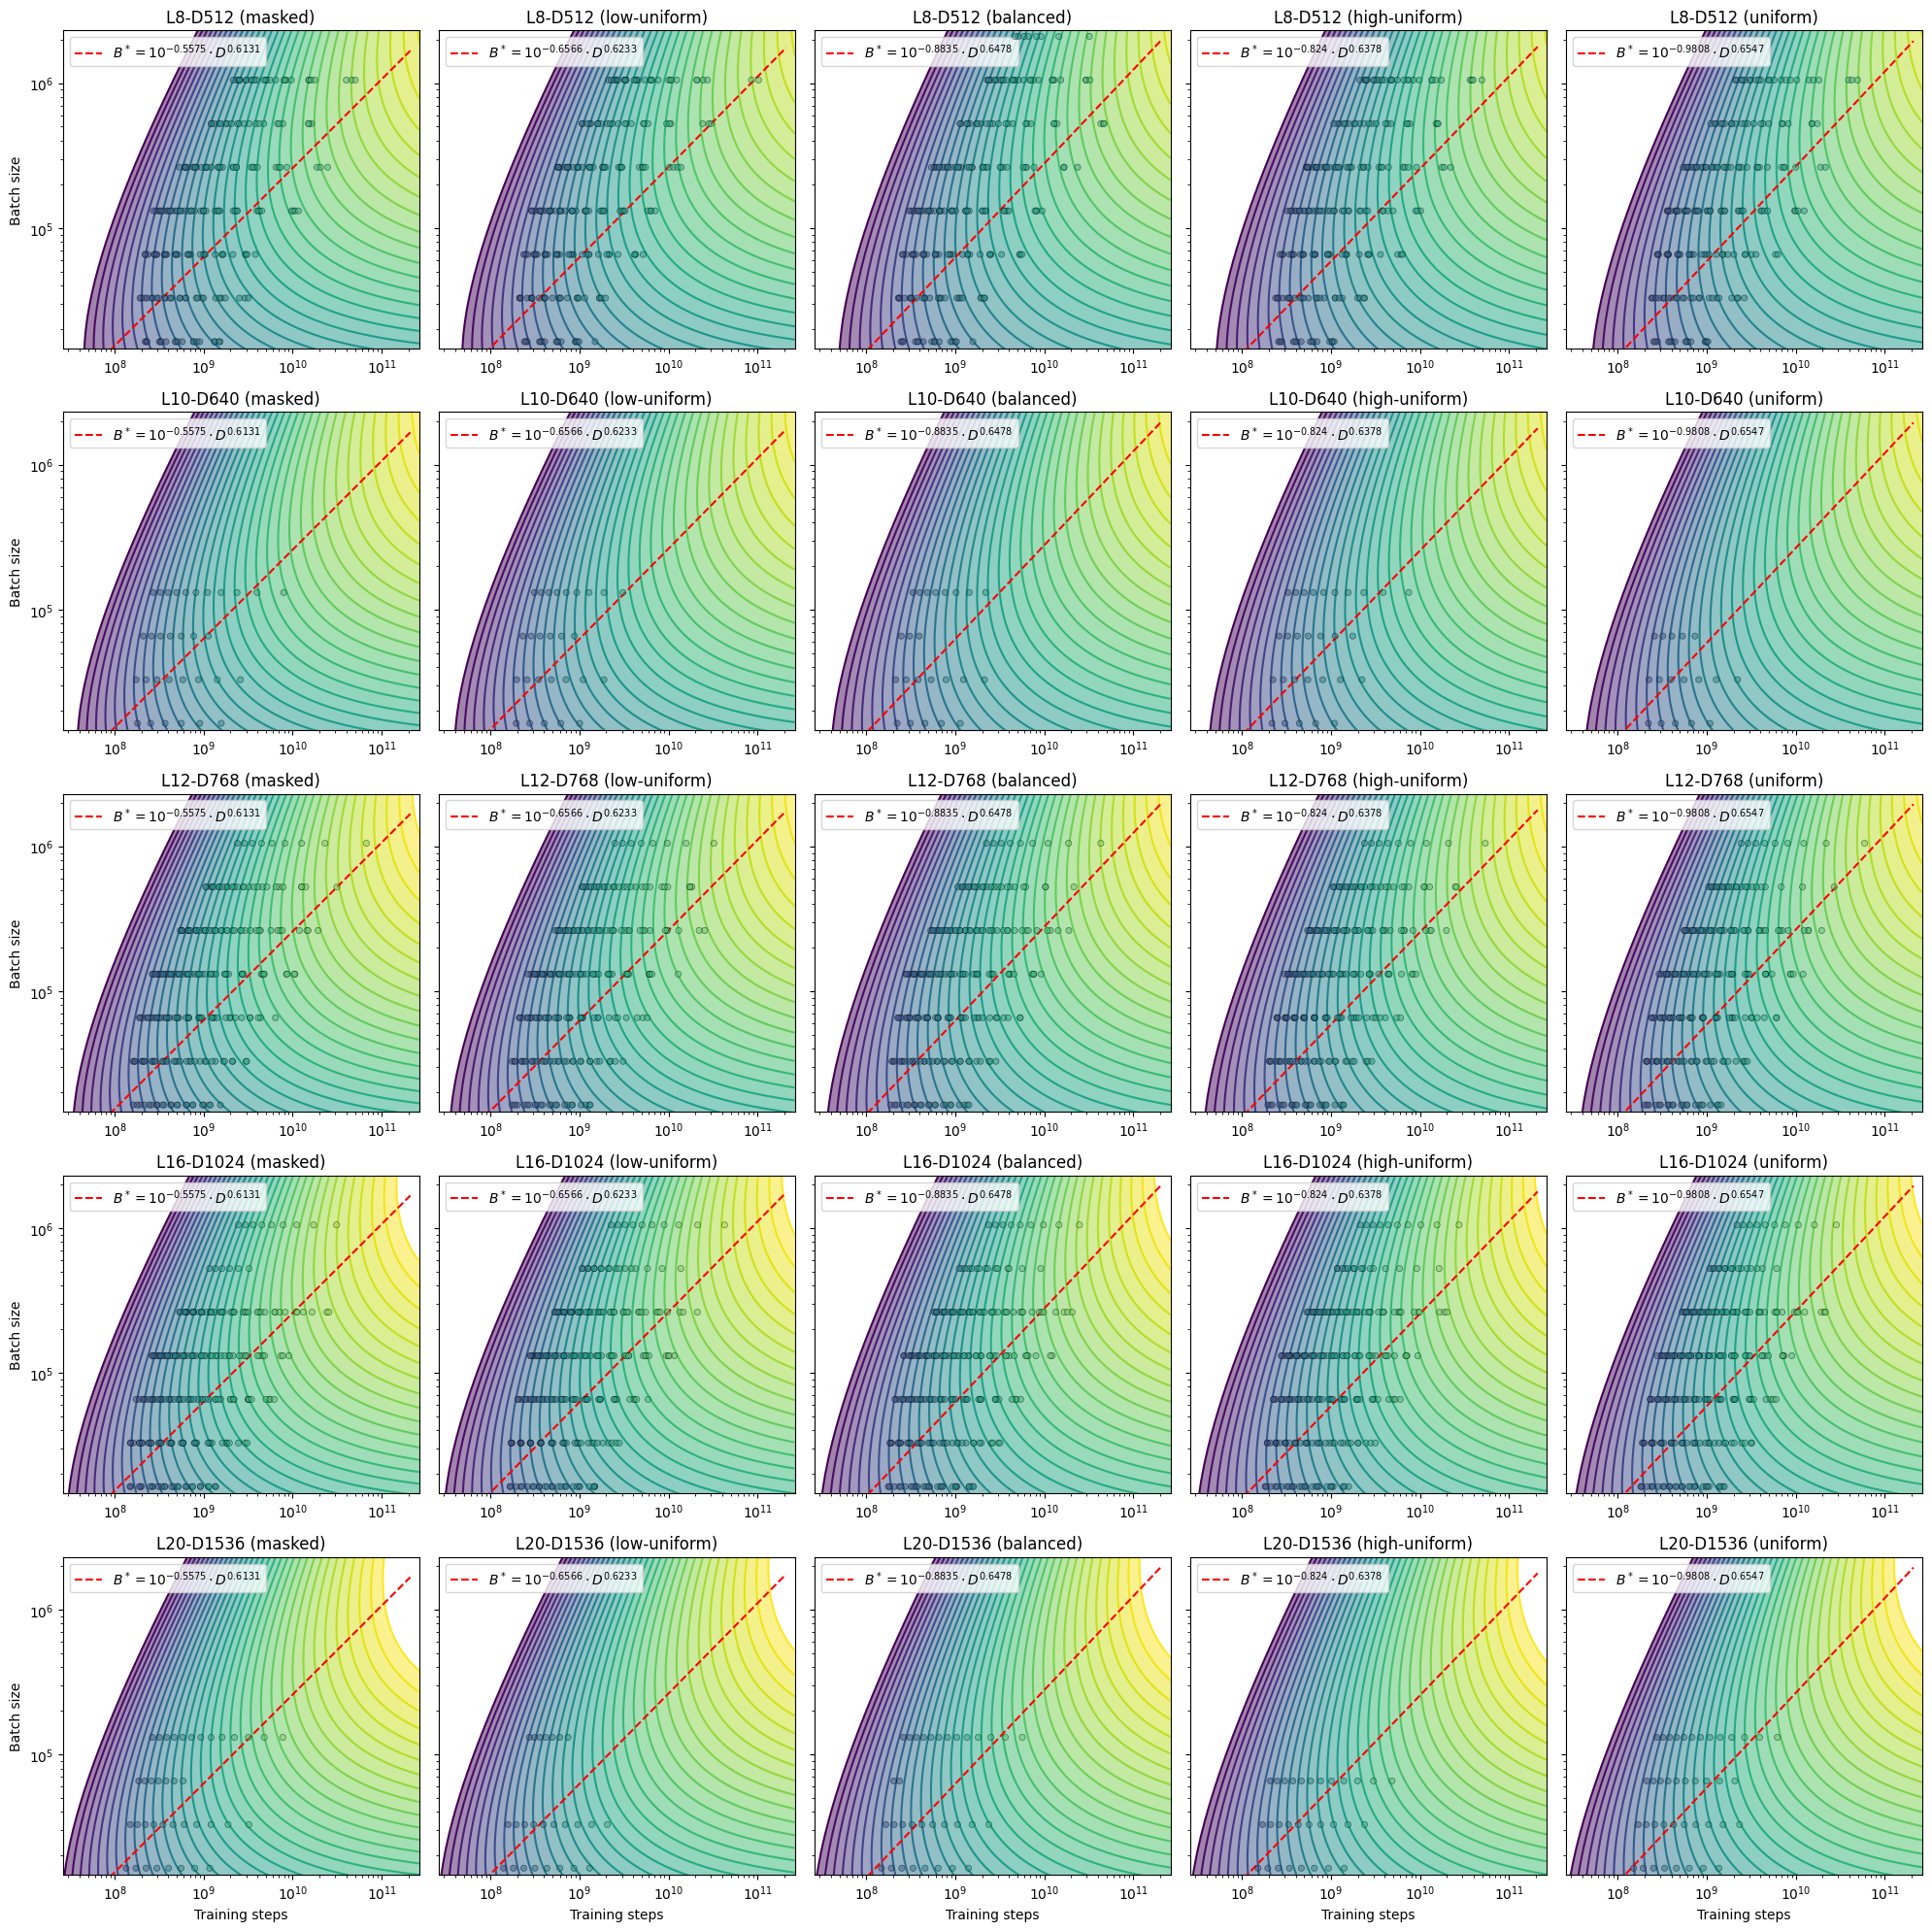

In [175]:
df_ = loss_df

cmap = plt.get_cmap("viridis_r")

fig, axs = plt.subplots(5, 5, figsize=(20, 20), sharey=True)

seq_len = 2048

vmin, vmax = 2.5, 5.0
xmin, xmax = df_["non_emb_params"].min(), df_["non_emb_params"].max()
ymin, ymax = 2000, 100_000
zmin, zmax = df_["batch_size"].min() * seq_len, df_["batch_size"].max() * seq_len
# levels = np.concatenate([[vmin], loss_targets[::-1], [vmax]])
levels = np.logspace(np.log10(vmin), np.log10(vmax), 33)
for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    # dfi = dfi.sort_values("batch_size")
    tokens = dfi["tokens"]
    batch_size = dfi["batch_size"] * seq_len
    params = dfi["non_emb_params"]
    steps = tokens / batch_size
    c = dfi["target_loss"]

    pad = 0.1
    mesh = np.meshgrid(
        sorted(params.unique()),
        np.logspace(np.log10(ymin*zmin)-pad, np.log10(ymax*zmax)+pad, 100),
        np.logspace(np.log10(zmin)-pad, np.log10(zmax)+pad, 100),
        indexing="ij",
    )
    mesh = list(mesh)

    mesh[1] = mesh[1] / mesh[2]
    mesh_val = f(mesh, *popts[hybrid_mixing_shift])
    mesh[1] = mesh[1] * mesh[2]

    for j, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
        ax = axs[j, i]

        vals = mesh_val[j]

        ids = np.argmin(vals, axis=1)

        cont = ax.contour(mesh[1][j], mesh[2][j], vals, levels=levels, cmap=cmap, alpha=1.0, vmin=vmin, vmax=vmax)
        ax.contourf(mesh[1][j], mesh[2][j], vals, levels=levels, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        sc = ax.scatter(dfj["tokens"], seq_len*dfj["batch_size"], c=dfj["target_loss"], s=20, marker="o", cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax, edgecolors="k", linewidths=0.5, zorder=10)

        opt_xs = mesh[1][j, :, 0]
        opt_ys = mesh[2][0, range(len(ids)), ids]
        # slope = (np.diff(np.log(opt_ys)) / np.diff(np.log(opt_xs))).mean()
        slope, bias = np.polyfit(np.log(opt_xs), np.log(opt_ys), 1)
        fit_x = np.logspace(np.log10(opt_xs).min()+pad, np.log10(opt_xs).max()-pad, 100)
        fit_y = opt_ys.mean() * (fit_x / opt_xs.mean())**slope
        # print(slope)
        ax.plot(fit_x, fit_y, color="red", linestyle="--", label=f"$B^* = 10^{{{np.log10(np.exp(bias)):.4g}}} \\cdot D^{{{slope:.4g}}}$")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(f"L{num_layers}-D{hidden_size} ({get_noise_label(hybrid_mixing_shift)})")
        ax.legend()
    # break
# fig.colorbar(sc, ax=ax, label="Loss")

ax.set_ylim(0.9*zmin, 1.1*zmax)

for ax in axs[-1, :]:
    ax.set_xlabel("Training steps")
for ax in axs[:, 0]:
    ax.set_ylabel("Batch size")

fig.tight_layout()
fig.show()

In [ ]:
import plotly.graph_objects as go

def f(xs, a=1.0, alpha=0.1, b=1.0, beta=1.0, c=1.0, gamma=1e-4, E=0.0):
    return np.exp(a) * xs[0]**-np.exp(alpha) + np.exp(b) * xs[1]**-np.exp(beta) + np.exp(c) * xs[2]**-np.exp(gamma) + np.exp(E)

df_ = loss_df.loc[loss_df["hybrid_mixing_shift"] == 0.0]

params = df_["non_emb_params"].values
bs = df_["batch_size"].values * 2048
steps = df_["tokens"].values / bs

pad = 0.0
xmin, xmax = params.min(), params.max()
ymin, ymax = steps.min(), steps.max()
zmin, zmax = bs.min(), bs.max()

nx = ny = nz = 50
xs = np.logspace(np.log10(xmin)-pad, np.log10(xmax)+pad, nx)
ys = np.logspace(np.log10(ymin*zmin)-pad, np.log10(ymax*zmax)+pad, ny)
zs = np.logspace(np.log10(zmin)-pad, np.log10(zmax)+pad, nz)

P, T, B = np.meshgrid(xs, ys, zs, indexing="ij")
S = T / B
vals = f((P, S, B), *popts[0.0])

# target_loss = df_["target_loss"].median()
# df_ = df_.loc[df_["target_loss"] == target_loss]
# target_loss = 4.5

fig = go.Figure(data=[
    go.Isosurface(
        x=P.ravel(),
        y=T.ravel(),
        z=B.ravel(),
        value=vals.ravel(),
        isomin=df_["target_loss"].min(),
        isomax=df_["target_loss"].max(),
        surface_count=10,
        caps=dict(x_show=False, y_show=False, z_show=False),
        showscale=True,
        colorbar=dict(title="loss"),
        colorscale="viridis_r",
    ),
    go.Scatter3d(
        x=params,
        y=(steps*bs),
        z=bs,
        mode="markers",
        marker=dict(size=3, opacity=0.9, color=df_["target_loss"], colorscale="viridis_r", cmin=df_["target_loss"].min(), cmax=df_["target_loss"].max()),
        name="data"
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title="params",
        yaxis_title="tokens",
        zaxis_title="batch_size",
        xaxis_type="log",
        yaxis_type="log",
        zaxis_type="log"
    ),
    width=900,
    height=800,
    title="Iso-loss surfaces"
)
fig.show()


In [ ]:
import plotly.graph_objects as go

def f(xs, a=1.0, alpha=0.1, b=1.0, beta=1.0, c=1.0, gamma=1e-4, E=0.0):
    return np.exp(a) * xs[0]**-np.exp(alpha) + np.exp(b) * xs[1]**-np.exp(beta) + np.exp(c) * xs[2]**-np.exp(gamma) + np.exp(E)

df_ = loss_df.loc[loss_df["hybrid_mixing_shift"] == 0.0]

params = df_["non_emb_params"].values
bs = df_["batch_size"].values * 2048
steps = df_["tokens"].values / bs

pad = 0.0
xmin, xmax = params.min(), params.max()
ymin, ymax = steps.min(), steps.max()
zmin, zmax = bs.min(), bs.max()

nx = ny = nz = 50
xs = np.logspace(np.log10(xmin)-pad, np.log10(xmax)+pad, nx)
ys = np.logspace(np.log10(ymin*zmin)-pad, np.log10(ymax*zmax)+pad, ny)
zs = np.logspace(np.log10(zmin)-pad, np.log10(zmax)+pad, nz)

P, T, B = np.meshgrid(xs, ys, zs, indexing="ij")
S = T / B
vals = f((P, S, B), *popts[0.0])

# target_loss = df_["target_loss"].median()
# df_ = df_.loc[df_["target_loss"] == target_loss]
# target_loss = 4.5

fig = go.Figure(data=[
    go.Scatter3d(
        x=params,
        y=(steps*bs),
        z=bs,
        mode="markers",
        marker=dict(size=3, opacity=0.9, color=df_["target_loss"], colorscale="viridis_r", cmin=df_["target_loss"].min(), cmax=df_["target_loss"].max()),
        name="data"
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title="params",
        yaxis_title="tokens",
        zaxis_title="batch_size",
        xaxis_type="log",
        yaxis_type="log",
        zaxis_type="log"
    ),
    width=900,
    height=800,
    title="Iso-loss surfaces"
)
fig.show()
